What variables should be used for training. We look at the performance of the default training vs the training with each variable removed. If the performance improves when we remove a variable, we know that variable is making the training worse. Further, by looking at the change in performance we can rank the variables to first order.

# Initalization

In [4]:
from bdt_training_scikit_tools import load_trimmed_sample, \
    test_train_samples, prep_samples, default_training, calc_performance, get_fraction_of_events, \
    default_training_variable_list
import matplotlib.pyplot as plt
plt.rc('font', size=14)
from matplotlib.colors import LogNorm
import pandas as pd
import numpy as np
import multiprocessing as mp
import itertools

# Load Data Samples

In [5]:
all_events_all = load_trimmed_sample("133")

Job 133:
  BIB: 800000 events
  Multijet: 800000 events
  Signal: 800000 events
  [800000, 800000, 473600]


In [6]:
all_events = get_fraction_of_events(all_events_all, 250000)
print ([len(e.index) for e in all_events])

[249223, 248728, 248506]


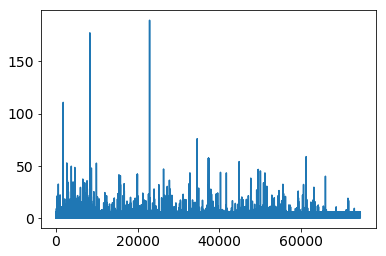

In [59]:
plt.plot(all_events[2].mc_Lz)

# Determine Full Variable List
We have to determine what variable list we want to start with before we start removing them according to their performance. Reasons for removal:

- Weight variables are MC only things
- Variables that have nothing to do with phyisics (like run #)
- DR to closest track because it is used later in the analysis
- JetPhi because physics *shouldn't* depend on that

In [7]:
all_events_all[0].columns

Index(['RunNumber', 'Weight', 'WeightMCEvent', 'WeightXSection',
       'WeightFlatten', 'mc_Lxy', 'mc_Lz', 'MHTOverHT', 'JetPt', 'JetPhi',
       'CalRatio', 'JetEta', 'NTracks', 'SumPtOfAllTracks', 'MaxTrackPt',
       'EventNumber', 'JetET', 'JetWidth', 'JetDRTo2GeVTrack', 'EnergyDensity',
       'HadronicLayer1Fraction', 'JetLat', 'JetLong', 'FirstClusterRadius',
       'NumberOfClusters', 'ShowerCenter', 'BIBDeltaTimingM',
       'BIBDeltaTimingP', 'FirstCellTiming', 'InteractionsPerCrossing',
       'RPredictedLxy', 'RPredictedLz', 'PredictedLxy', 'PredictedLz',
       'PredictedLxyHighEta', 'PredictedLxyLowEta', 'PredictedLzHighEta',
       'PredictedLzLowEta'],
      dtype='object')

In [8]:
variable_list = set(all_events_all[0].columns) - set(['RunNumber', 'Weight', 'WeightMCEvent', 'WeightXSection', 'WeightFlatten', 'mc_Lxy', 'mc_Lz', 'MHTOverHT', 'JetPhi', 'EventNumber', 'InteractionsPerCrossing', 'JetDRTo2GeVTrack', 'JetET'])

# Remove badly modeled items
variable_list = variable_list - set(['BIBDeltaTimingM', 'BIBDeltaTimingP', 'FirstCellTiming', 'NumberOfClusters'])

variable_list

{'CalRatio',
 'EnergyDensity',
 'FirstClusterRadius',
 'HadronicLayer1Fraction',
 'JetEta',
 'JetLat',
 'JetLong',
 'JetPt',
 'JetWidth',
 'MaxTrackPt',
 'NTracks',
 'PredictedLxy',
 'PredictedLxyHighEta',
 'PredictedLxyLowEta',
 'PredictedLz',
 'PredictedLzHighEta',
 'PredictedLzLowEta',
 'RPredictedLxy',
 'RPredictedLz',
 'ShowerCenter',
 'SumPtOfAllTracks'}

# Drop First Variable

In [9]:
%%writefile get_training_performance.py
from bdt_training_scikit_tools import load_default_samples, default_training_variable_list, \
    test_train_samples, prep_samples, default_training, calc_performance
    
def do_training (vlist):
    all_events, training_list = vlist
    return get_training_performance (all_events, training_list)
    
def get_training_performance (all_events, training_list):
    '''Run a training with the set of varaibles given. Return a performance table.'''
    
    # Split into testing and training samples
    train, test = test_train_samples(all_events)
        
    # Prep samples for training
    all_events, all_events_class, training_weight, evaluation_weight = prep_samples(train[0], train[1], train[2], training_variable_list=training_list)
    
    # Run training
    bdt = default_training(all_events, training_weight, all_events_class, estimators=400)
    
    # Create a thing of all the results
    return {tuple(training_list): calc_performance(bdt, test, training_variables = training_list)}

Overwriting get_training_performance.py


In [10]:
def all_but_one (vlist, number_to_drop = 1):
    '''Return vlist and vlist with each item removed
    
    Arguments:
        vlist - the source list or tuple
        number_to_drop - return a list that is len(vlist)-number_to_drop - all possible combinations
        
    Returns:
        A list of tuples that have len(vlist)-number_to_drop items.
    
    '''
    var_training_list = itertools.combinations(vlist, len(vlist)-number_to_drop)
    var_training_list = list(var_training_list) + [tuple(vlist)]
    return var_training_list

In [11]:
import get_training_performance
pool = mp.Pool(processes=10)

def unused_var(original_list, used_list):
    r = tuple(i for i in original_list if i not in used_list)
    r = r if len(r) != 0 else ('None',)
    return r

def calc_var_removal(all_events, training_list = default_training_variable_list):
    r_drop_first = pool.map(get_training_performance.do_training,
             [(all_events, tvar_list) for tvar_list in all_but_one(training_list)])

    one_dict = {}
    for kp in r_drop_first:
        one_dict.update(kp)

    return pd.DataFrame({unused_var(training_list, k):one_dict[k] for k in one_dict}).T

In [12]:
def remove_all_variables(all_events, training_list = variable_list):
    done = False
    count = 0
    rlist = []
    while not done:
        count = count + 1
        print ("Iteration #{0}".format(count))
        print ('  Training with variable list:')
        print ('  ' + str(training_list))
        result = calc_var_removal(all_events, training_list=training_list)
        result_sorted = result.sort_values("HSSSsqrtB")
        rlist = rlist + [result_sorted]
        print (result_sorted.HSSSsqrtB)
        last_var_name = result_sorted.index[-1][0]
        done = last_var_name == 'None'
        if not done:
            training_list = training_list - set([last_var_name])
    return rlist

In [ ]:
%%time
#r_drop_first = calc_var_removal(all_events)

In [ ]:
#print (r_drop_first.sort_values("HSSSsqrtB").HSSSsqrtB)

In [ ]:
%%time
r = remove_all_variables(all_events, variable_list)

In [ ]:
len(r)

In [ ]:
r[-1]

In [ ]:
r[-2]

# Look at high $\eta$ and low $\eta$ list

In [ ]:
%%time
r_low_high = remove_all_variables(all_events, variable_list - {'RPredictedLxy', 'RPredictedLz', 'PredictedLxy', 'PredictedLz'})

In [ ]:
r_low_high[-1]

# Look at full $\eta$ range predictions

In [ ]:
r_full = remove_all_variables(all_events,variable_list - {'RPredictedLxy', 'RPredictedLz',
       'PredictedLxyHighEta', 'PredictedLxyLowEta', 'PredictedLzHighEta', 'PredictedLzLowEta'})

Iteration #1
  Training with variable list:
  {'HadronicLayer1Fraction', 'ShowerCenter', 'JetPt', 'EnergyDensity', 'PredictedLxy', 'JetEta', 'CalRatio', 'SumPtOfAllTracks', 'FirstClusterRadius', 'PredictedLz', 'JetLong', 'JetLat', 'JetWidth', 'NTracks', 'MaxTrackPt'}
JetPt                     43.107377
PredictedLxy              47.562450
HadronicLayer1Fraction    48.026731
JetWidth                  50.580667
PredictedLz               53.765309
EnergyDensity             53.915787
CalRatio                  54.612296
None                      54.851410
NTracks                   54.988874
JetLat                    57.132146
ShowerCenter              57.762591
FirstClusterRadius        58.515834
JetLong                   59.677550
SumPtOfAllTracks          60.827853
JetEta                    62.057423
MaxTrackPt                62.818081
Name: HSSSsqrtB, dtype: float64
Iteration #2
  Training with variable list:
  {'HadronicLayer1Fraction', 'ShowerCenter', 'JetPt', 'EnergyDensity', 'Predicte

In [37]:
for index, r in enumerate(r_full):
    print("Iteration {0}:".format(index))
    print("==============")
    print(list(r.index.levels[0]))
    print(r.HSSSsqrtB)
    print("")

Iteration 0:
['CalRatio', 'EnergyDensity', 'FirstClusterRadius', 'HadronicLayer1Fraction', 'JetEta', 'JetLat', 'JetLong', 'JetPt', 'JetWidth', 'MaxTrackPt', 'NTracks', 'None', 'PredictedLxy', 'PredictedLz', 'ShowerCenter', 'SumPtOfAllTracks']
JetPt                     43.107377
PredictedLxy              47.562450
HadronicLayer1Fraction    48.026731
JetWidth                  50.580667
PredictedLz               53.765309
EnergyDensity             53.915787
CalRatio                  54.612296
None                      54.851410
NTracks                   54.988874
JetLat                    57.132146
ShowerCenter              57.762591
FirstClusterRadius        58.515834
JetLong                   59.677550
SumPtOfAllTracks          60.827853
JetEta                    62.057423
MaxTrackPt                62.818081
Name: HSSSsqrtB, dtype: float64

Iteration 1:
['CalRatio', 'EnergyDensity', 'FirstClusterRadius', 'HadronicLayer1Fraction', 'JetEta', 'JetLat', 'JetLong', 'JetPt', 'JetWidth', 'NTra

In [42]:
r_full[0].columns

Index(['BIBBack', 'BIBEff', 'BIBSsqrtB', 'BIBTotalCount', 'BIBTotalWeight',
       'BIBinBIB', 'BIBinHSS', 'BIBinMJ', 'HSSBack', 'HSSEff', 'HSSSsqrtB',
       'HSSTotalCount', 'HSSTotalWeight', 'HSSinBIB', 'HSSinHSS', 'HSSinMJ',
       'MJBack', 'MJEff', 'MJSsqrtB', 'MJTotalCount', 'MJTotalWeight',
       'MJinBIB', 'MJinHSS', 'MJinMJ'],
      dtype='object')

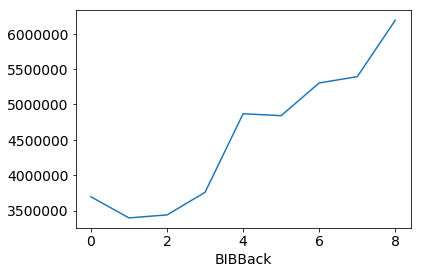

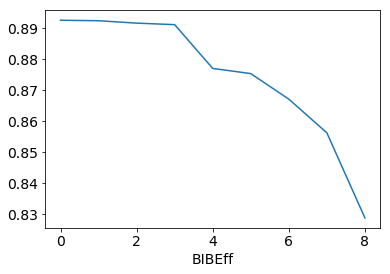

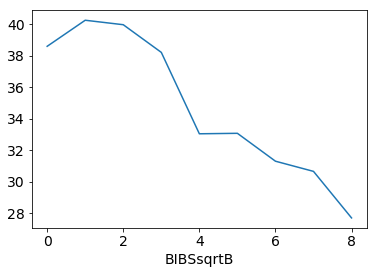

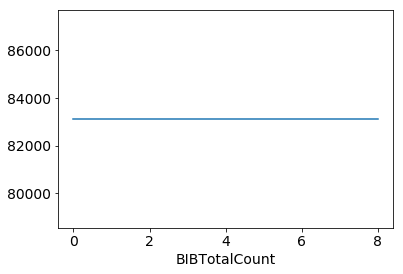

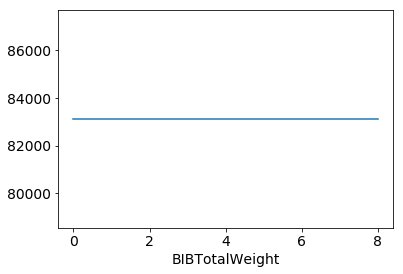

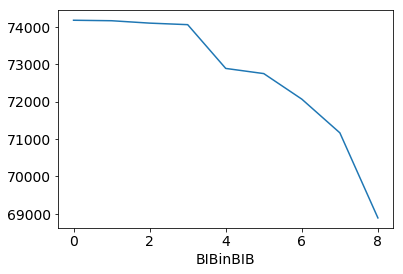

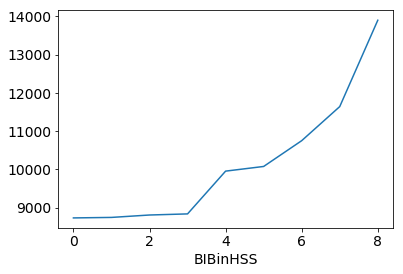

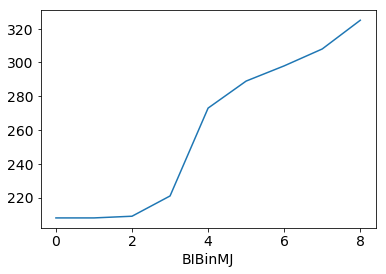

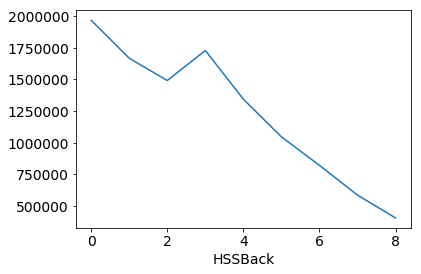

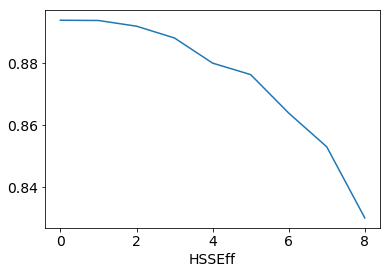

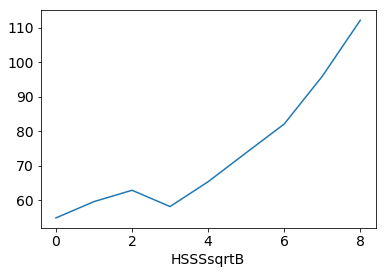

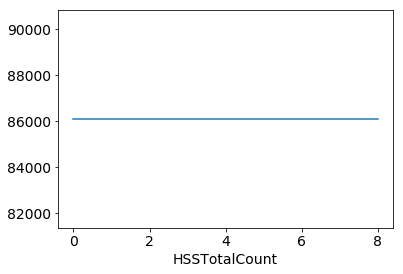

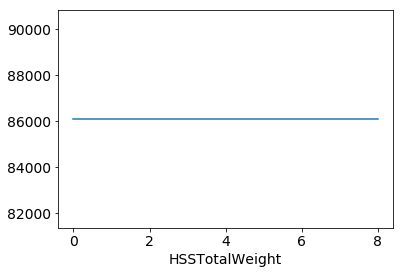

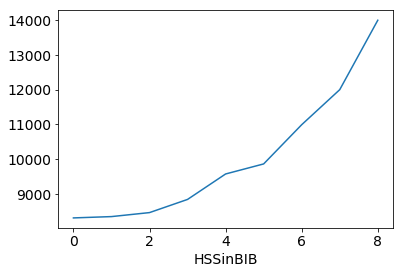

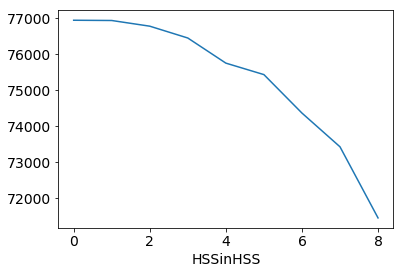

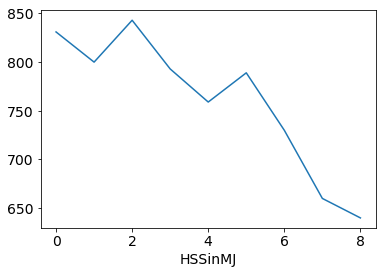

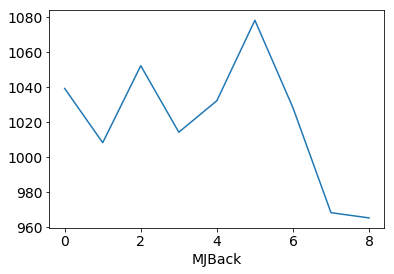

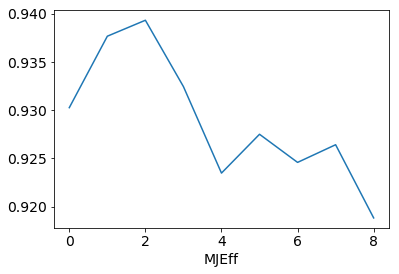

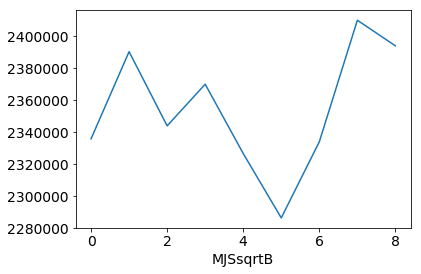

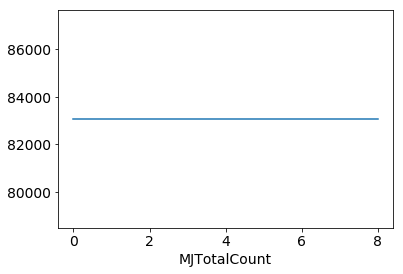

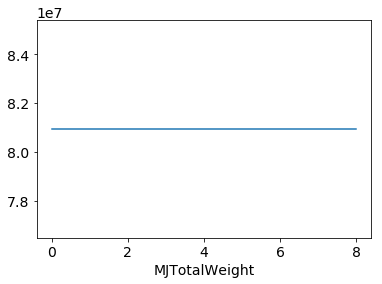

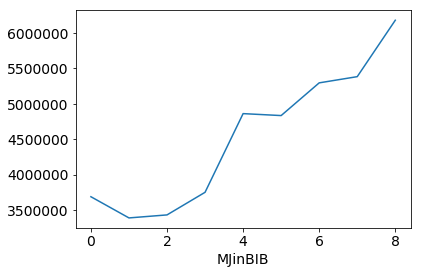

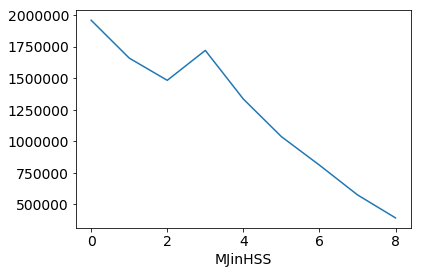

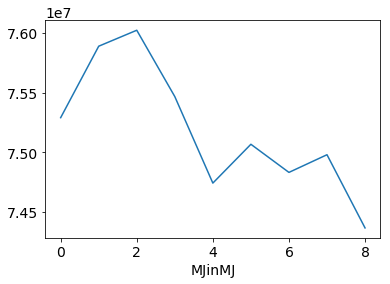

In [56]:
def plot_one(df_list, name):
    values = [float(df[name]['None']) for df in df_list]
    
    plt.plot(values)
    plt.xlabel(name)
    plt.show()
    
for c in r_full[0].columns:
    plot_one(r_full, c)

# Using original Rachel $L_{xy}$ and $L_{z}$ predictions

In [60]:
r_rachel = remove_all_variables(all_events,variable_list - {'PredictedLxy', 'PredictedLz',
       'PredictedLxyHighEta', 'PredictedLxyLowEta', 'PredictedLzHighEta', 'PredictedLzLowEta'})

Iteration #1
  Training with variable list:
  {'RPredictedLxy', 'HadronicLayer1Fraction', 'ShowerCenter', 'JetPt', 'EnergyDensity', 'RPredictedLz', 'JetEta', 'CalRatio', 'SumPtOfAllTracks', 'FirstClusterRadius', 'JetLong', 'JetLat', 'JetWidth', 'NTracks', 'MaxTrackPt'}
JetPt                     47.386434
HadronicLayer1Fraction    49.305134
JetWidth                  50.614487
NTracks                   52.115797
RPredictedLxy             54.813348
RPredictedLz              56.014088
ShowerCenter              56.245898
CalRatio                  57.831737
EnergyDensity             58.008460
JetEta                    58.398374
JetLat                    60.005942
None                      60.060881
JetLong                   61.007185
FirstClusterRadius        61.510342
SumPtOfAllTracks          61.744245
MaxTrackPt                62.728188
Name: HSSSsqrtB, dtype: float64
Iteration #2
  Training with variable list:
  {'RPredictedLxy', 'HadronicLayer1Fraction', 'ShowerCenter', 'JetPt', 'Energy

In [61]:
for index, r in enumerate(r_full):
    print("Iteration {0}:".format(index))
    print("==============")
    print(list(r.index.levels[0]))
    print(r.HSSSsqrtB)
    print("")

Iteration 0:
['CalRatio', 'EnergyDensity', 'FirstClusterRadius', 'HadronicLayer1Fraction', 'JetEta', 'JetLat', 'JetLong', 'JetPt', 'JetWidth', 'MaxTrackPt', 'NTracks', 'None', 'PredictedLxy', 'PredictedLz', 'ShowerCenter', 'SumPtOfAllTracks']
JetPt                     43.107377
PredictedLxy              47.562450
HadronicLayer1Fraction    48.026731
JetWidth                  50.580667
PredictedLz               53.765309
EnergyDensity             53.915787
CalRatio                  54.612296
None                      54.851410
NTracks                   54.988874
JetLat                    57.132146
ShowerCenter              57.762591
FirstClusterRadius        58.515834
JetLong                   59.677550
SumPtOfAllTracks          60.827853
JetEta                    62.057423
MaxTrackPt                62.818081
Name: HSSSsqrtB, dtype: float64

Iteration 1:
['CalRatio', 'EnergyDensity', 'FirstClusterRadius', 'HadronicLayer1Fraction', 'JetEta', 'JetLat', 'JetLong', 'JetPt', 'JetWidth', 'NTra

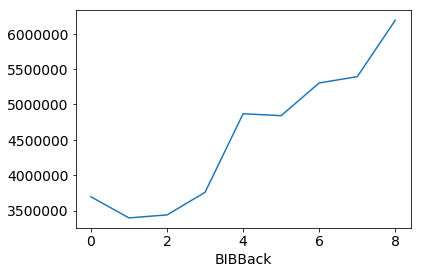

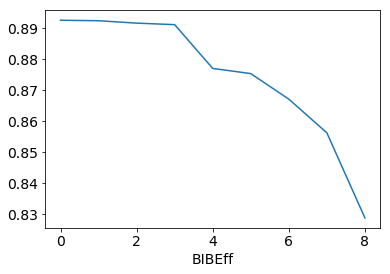

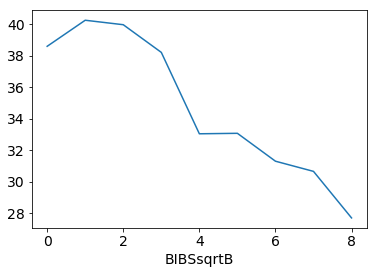

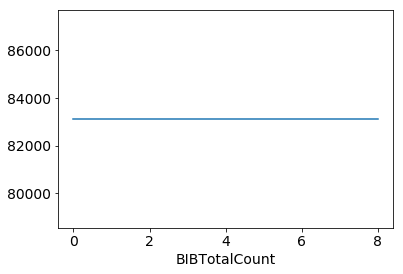

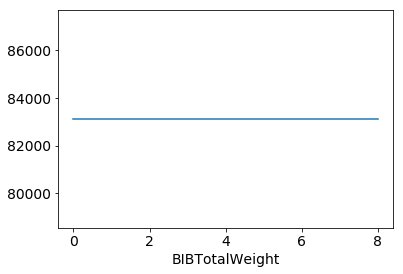

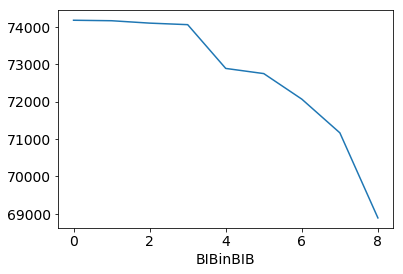

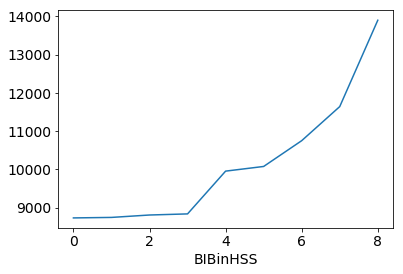

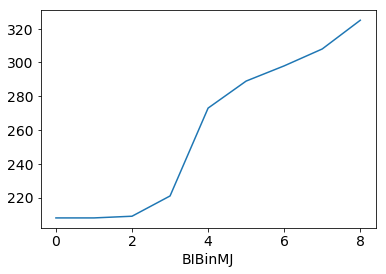

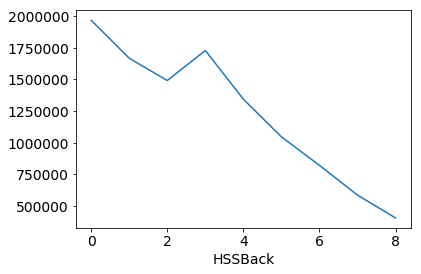

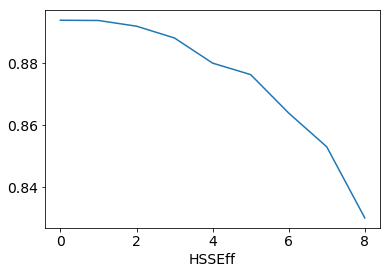

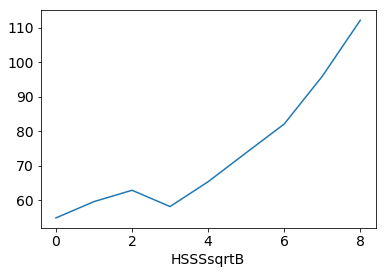

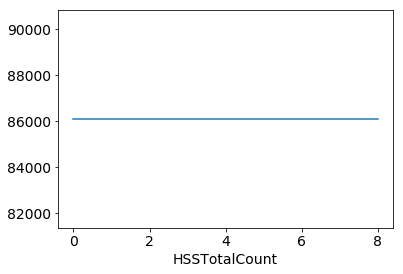

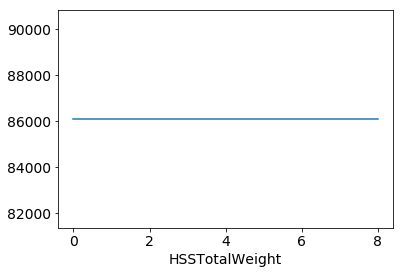

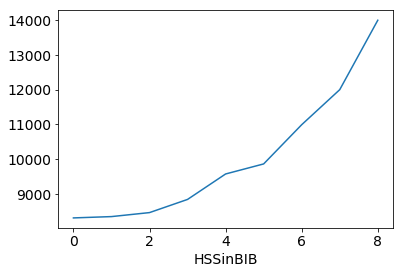

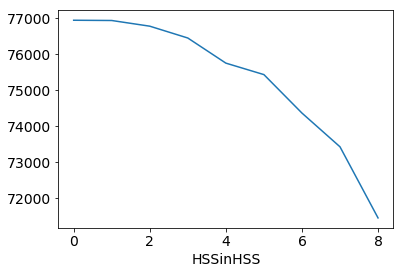

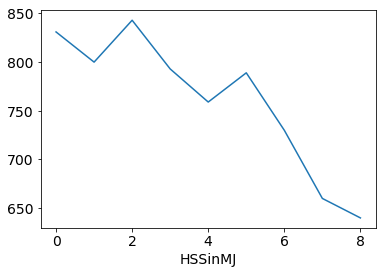

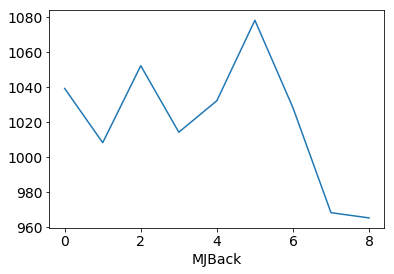

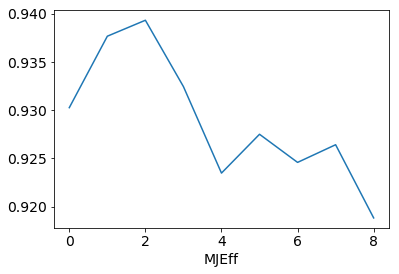

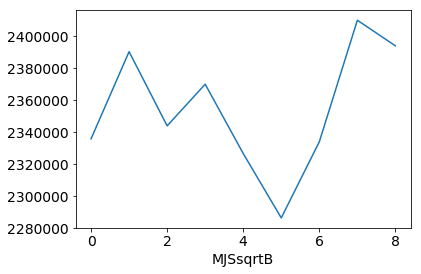

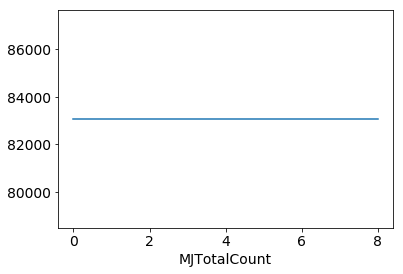

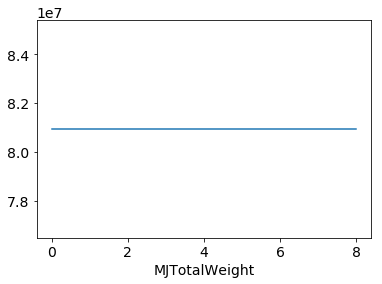

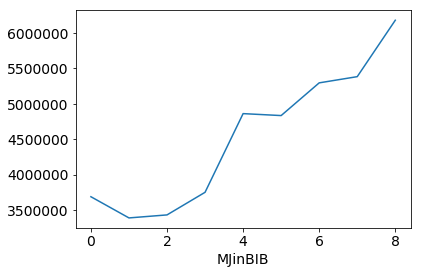

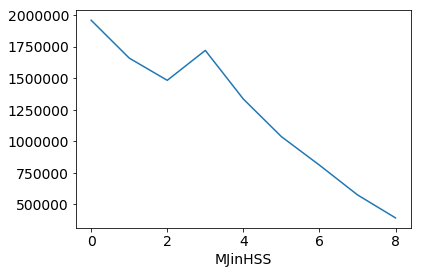

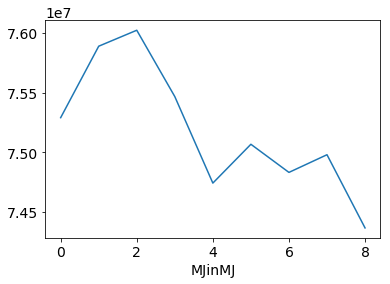

In [62]:
def plot_one(df_list, name):
    values = [float(df[name]['None']) for df in df_list]
    
    plt.plot(values)
    plt.xlabel(name)
    plt.show()
    
for c in r_full[0].columns:
    plot_one(r_full, c)

In [63]:
i = 10